# EXP 15. 다양한 OCR 모델 비교하기 📟


* 이번 시간에는 그림에 있는 문자를 인식 해 출력 해보는 작업을 해 보았습니다. 작업에는 유료 구글 API 부터 직접 구축 해 볼 수 있는 모델까지, 총 3가지의 OCR 모델을 사용 해 보았습니다. 


* 이번 프로젝트에선 어떤 OCR 모델을 사용하는 게 좋을지, 모델을 구축해서, 20개 가량의 글자가 포함된 이미지 파일을 통해 비교 해 봅니다. 







----





# 루브릭 평가 기준 


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가? | 목표로 하는 서비스가 OCR를 적용 가능하며,  OCR을 활용했을 때 더욱 유용해진다. |
| 2. 모델 평가기준이 명확하고 체계적으로 세워졌는가? | 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다. |
| 3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가? | 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다 |





----





# 목차 


## 1. 데이터 및 라이브러리 불러오기 


## 2. 구글 OCR API 사용 해 보기


## 3. Keras-OCR 모델 사용 해 보기


## 4. 테서랙트 OCR 모델 사용 해 보기


## 5. 세 모델 비교


## 회고


## 🖇️ 참고 페이지 





----





# 1. 데이터 및 라이브러리 불러오기 


* 프로젝트에 필요한 라이브러리를 불러옵니다.
* 검증용 데이터셋을 준비합니다. 데이터셋은 한국 고속도로 표지판을 준비해 봤습니다. 
  표지판에 있는 글자를 읽어, 가려는 목적지나, 휴게소, 공사중 표지판 등을 읽어 판별할 수 있다면, 좋을것 같아 시도 해 보려합니다.  

## &nbsp;&nbsp; 1-1 라이브러리 불러오기 


* 이번 프로젝트에 필요한 라이브러리를 불러옵니다.

In [44]:
import keras_ocr
import pytesseract

from google.cloud import vision
import io, os 
import matplotlib.pyplot as plt

from PIL import Image
from pytesseract import Output

In [2]:
# 주요 라이브러리 버전을 확인 합니다.
print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## &nbsp;&nbsp; 1-2 검증용 데이터셋 준비하기


* 준비한 한국 고속도로 표지판 이미지를 주피터 노트북 폴더에 넣어줍니다. 
* 검증용 이미지 경로를 지정합니다. 이미지 경로를 list에 담아주면, 검증 시 이미지를 불러오기 쉽겠죠?

In [22]:
# 이미지 경로를 불러온 다음, list에 담아줍니다. 
img_path = os.getenv('HOME')+'/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img'
img_list = os.listdir(img_path)

img_list

['highway_sign 6.jpg',
 'highway_sign 5.jpg',
 'highway_sign 2.jpg',
 'highway_sign 1.jpg',
 'highway_sign 3.jpg',
 'highway_sign 4.jpg']





----





# 2. 구글 OCR API 사용 해 보기


## &nbsp;&nbsp; 2-1 구글의 파이썬 API 인터페이스 모듈 설치


* 모듈은 클라우드 상에 이미 설치되어 있으니 확인만 하고 넘어갔습니다. 

In [ ]:
# $ pip install --upgrade google-api-python-client
# $ pip install google-cloud-vision

## &nbsp;&nbsp; 2-2 Google Cloud Vision API 사용


[이 페이지!](https://kimchangheon.tistory.com/166)를 참고하여 서비스 계정 및 인증키를 생성합니다. 
- 브라우저에서 다운로드한 인증키는 `my_google_api_key.json`이라는 파일명으로 변경합시다.   
  (파일은 프로젝트 이름으로 시작하는 파일명으로 자동 저장됩니다.)
- `cloud jupyter` 를 열고 `my_google_api_key.json` 파일을  `~/aiffel/ocr_python` 디렉터리에 업로드해 주세요.


## &nbsp;&nbsp; 2-3 API 사용 테스트 


* 사용할 이미지를 cloud jupyter를 이용하여 업로드 후 경로를 지정해 주세요
* 원래 쓰던 계정에서, 이전에 API를 발급한 적이 있어 무료기간이 끝났다 ^^...

In [30]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [36]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요. => img_list에 저장 
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.

for img in img_list:
    print(f'[{img}]')
    detect_text(os.path.join(img_path, img))
    print('*'*50)


[highway_sign 6.jpg]
Texts:

"←판교
↑인천
김포→
서울외곽순환고속도로
Seouloegwaksunhwan Expressway
100
100
←판교
|↑ 인천
김포→
수도권제1순환고속도로
Sudogwon Jelsunhwan Expressway
100
100
"

"←"

"판교"

"↑"

"인천"

"김포"

"→"

"서울"

"외곽"

"순환"

"고속도로"

"Seouloegwaksunhwan"

"Expressway"

"100"

"100"

"←"

"판교"

"|"

"↑"

"인천"

"김포"

"→"

"수도권"

"제"

"1"

"순환"

"고속도로"

"Sudogwon"

"Jelsunhwan"

"Expressway"

"100"

"100"
bounds: (485,305),(525,305),(525,328),(485,328)
**************************************************
[highway_sign 5.jpg]
Texts:

"9 |동홍천K
인제
44
양양
Yangyang
60 내촌
Inje
홍천
Hongcheon 1.5km
Naechon
60 동홍천44-
65 속초
"

"9"

"|"

"동"

"홍천"

"K"

"인제"

"44"

"양양"

"Yangyang"

"60"

"내촌"

"Inje"

"홍천"

"Hongcheon"

"1.5km"

"Naechon"

"60"

"동"

"홍천"

"44-"

"65"

"속초"
bounds: (753,563),(802,560),(803,583),(754,586)
**************************************************
[highway_sign 2.jpg]
Texts:

"|14| 양양 1
13A13B|양양분기점
44) 양양
56 Yangyang
북N
속초
65
강릉
낙산사 Naksansa
Sokcho
65
Gangneung
|설악산국립공원(오색지구)
"

"|"

"14"

"|"





----





# 3. Keras-OCR 모델 사용 해 보기


- 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR 을 할 수 있게 해줍니다.
- **검출 모델로는 CRAFT(Character Region Awareness for Text Detection)를 사용**하고,   
  **인식 모델로는 앞에서 설명한 CRNN을 사용**합니다.
  
  
* **keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델입니다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의해 주세요!** 

## &nbsp;&nbsp; 3-1 필요한 모델 자동으로 다운로드 받기.

In [37]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


## &nbsp;&nbsp; 3-2 recognize() 에 검증용 이미지 넣기 


* LMS 상에선 이미지 소스의 URL을 이용해 이미지를 가져왔지만, 여기선 준비한 데이터셋의 경로를 넣어줍니다.

In [38]:
images = [ keras_ocr.tools.read(os.path.join(img_path, img)) for img in img_list]
prediction_groups = [pipeline.recognize([os.path.join(img_path, img)]) for img in img_list]

## &nbsp;&nbsp; 3-3 인식된 결과를 pyplot으로 시각화 합니다. 


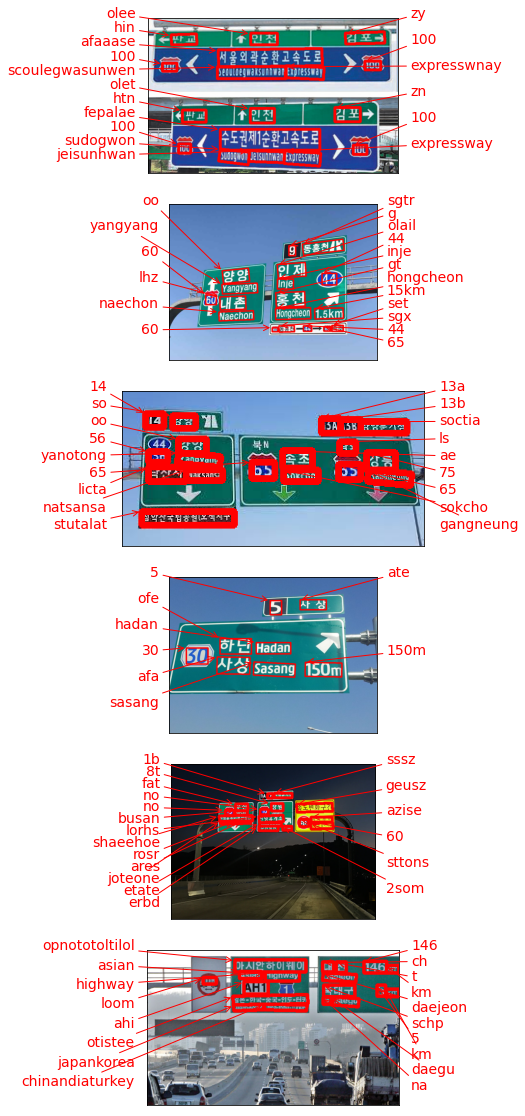

In [39]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

* 한국어로 학습되지 않은 모델이기 때문에, 한국어가 알아볼 수 없는 영문 단어로 출력되는 것을 확인할 수 있다. 그 외, 영어나 숫자인 부분은 정확하게 인식 하는 것을 확인 할 수 있다. 





----





# 4. 테서랙트 OCR 모델 사용 해 보기


### 테서랙트란?
- 구글에서 후원하는 OCR **오픈소스** 라이브러리
- 현재는 버전 4와 Tesseract.js 등으로 확장되는 등, 많은 곳에서 사용되고 있음.
    - 버전 4에선 LSTM이 엔진에 추가되었고, 현재 **한국어를 포함한 116개 국어**를 지원함.
- 한 번에 이미지 내의 문자 검출과 인식을 할 수 있음.

## &nbsp;&nbsp; 4-1 테서랙트 설치하기


- 클라우드에는 이미 설치되어 있기 때문에, 확인만 하고 넘어갑니다.

In [40]:
# $ sudo apt install tesseract-ocr
# $ sudo apt install libtesseract-dev

## &nbsp;&nbsp; 4-2 테서랙트 파이썬 wrapper 설치하기 



* `Pytesseract`를 설치합니다. 
    - OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)
    - 파이썬 내에서 테서랙트 엔진의 기능을 바로 쓸 수 있게 해주는 기능을 합니다. 
    
* 클라우드에는 이미 설치되어 있습니다. 

In [43]:
# 설치 여부 확인 
# $ pip list | grep pytesseract

## &nbsp;&nbsp; 4-3 테서랙트 언어팩 설치하기 


* 한국 고속도로 표지판인 만큼, 한글이 포함되어 있으므로 언어팩을 설치해 한국어도 인식할 수 있게 바꿔줍니다.
* 근데 한국어 말고도 영어도 있는데, lang을 kor 로만 하면 영어는 인식되지 않는건가? 
* [언어팩 설치 관련 참고 페이지](https://blog.daum.net/rayolla/1141)  


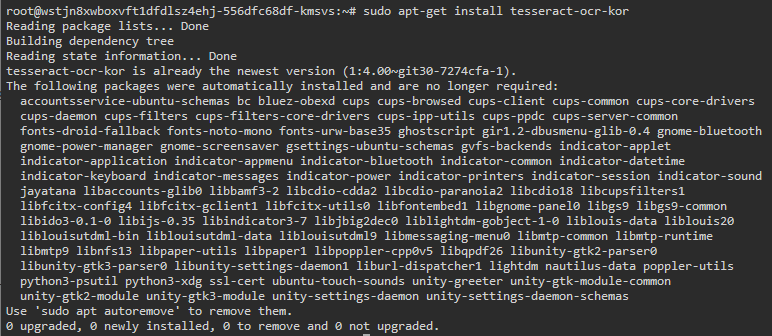
- kor 언어팩 설치 완료!

## &nbsp;&nbsp; 4-4 테서랙트로 문자 검출하고 이미지 자르기 (detection) 


In [95]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.jpg', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng+kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.jpg")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list



In [96]:
# 이미지 하나를 불러와 저장해 보겠습니다 
save_path = os.getenv('HOME')+'/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/'
one_img = save_path + '/highway_sign 6.jpg'
cropped_image_path_list = crop_word_regions(one_img, save_path)

/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0000.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0001.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0002.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0003.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0004.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0005.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0006.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0007.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0008.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0009.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img/0010.jpg


## &nbsp;&nbsp; 4-5 테서랙트로 잘린 이미지에서 단어 인식하기

- 문자 인식을 해 봅시다.
- 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 
`image_to_string()`를 사용하게 됨
- 인식된 결과와 실제 이미지가 맞는지 확인 해봅시다.

In [97]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng+kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [98]:
recognize_images(cropped_image_path_list)

Ai:

g


ri

스

7

구 소 도 로

0

Moe 이

》

eae =

Done


In [99]:
sign1_path = os.getenv('HOME')+'/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img01/'
sign1 = save_path + '/highway_sign 1.jpg'
cropped_image_path_list = crop_word_regions(sign1, sign1_path)

recognize_images(cropped_image_path_list)

/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img01/0000.jpg
pi = 기

Done


In [101]:
sign2_path = os.getenv('HOME')+'/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img02/'
sign2 = save_path + '/highway_sign 2.jpg'
cropped_image_path_list = crop_word_regions(sign2, sign2_path)

recognize_images(cropped_image_path_list)

/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img02/0000.jpg

Done


In [102]:
sign3_path = os.getenv('HOME')+'/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img03/'
sign3 = save_path + '/highway_sign 3.jpg'
cropped_image_path_list = crop_word_regions(sign3, sign3_path)

recognize_images(cropped_image_path_list)

/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img03/0000.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img03/0001.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img03/0002.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img03/0003.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img03/0004.jpg
ee


|

oe ee

대 2

Done


In [103]:
sign4_path = os.getenv('HOME')+'/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/'
sign4 = save_path + '/highway_sign 4.jpg'
cropped_image_path_list = crop_word_regions(sign4, sign4_path)

recognize_images(cropped_image_path_list)

/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0000.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0001.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0002.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0003.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0004.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0005.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0006.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0007.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0008.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0009.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0010.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0011.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR_model/img04/0012.jpg
/aiffel/aiffel/EXPLOLATION/220224_EXP15_Compare_OCR

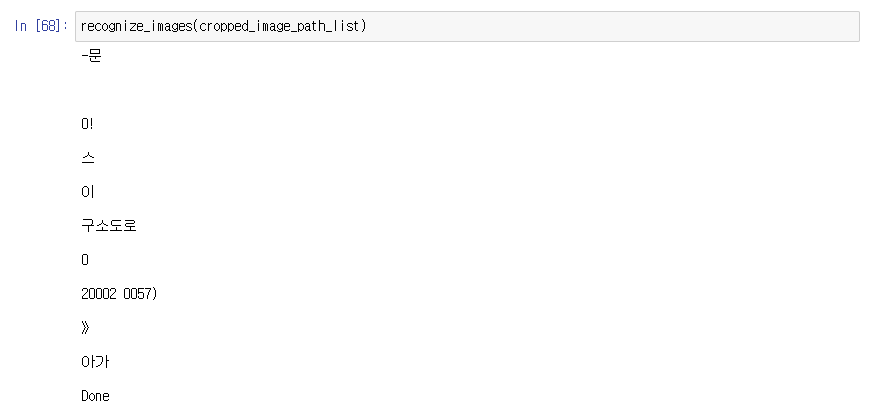

* 이미지를 바꿔봐도 결과는 그대로. lang 부분에 'kor' 만 적혀있으니 영어가 아예 인식되지 않은것 같다.


## &nbsp;&nbsp; 4-6 lang 값에 달라지는 출력 값 비교 


* lang에 2가지 언어를 넣을 수 없을까 찾아보던차, 'eng+kor' 로 변경하여 선언하면 된다는 글을 보고, 3가지 경우를 비교해 보고싶어졌다.
* highway_sign 6 이미지를 가지고 test 해 봅니다. 
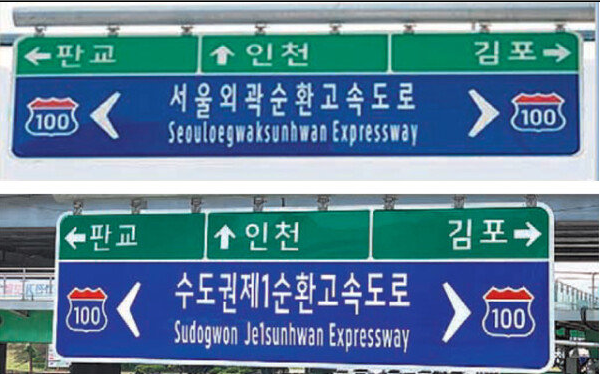

### case 1. lang = kor 


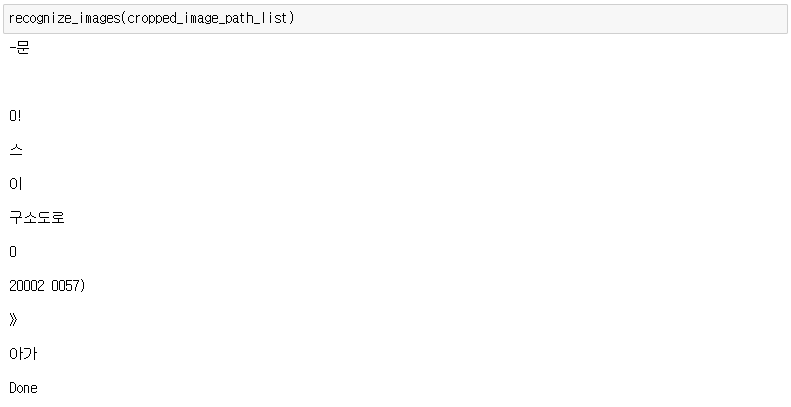

### case 2. lang = eng


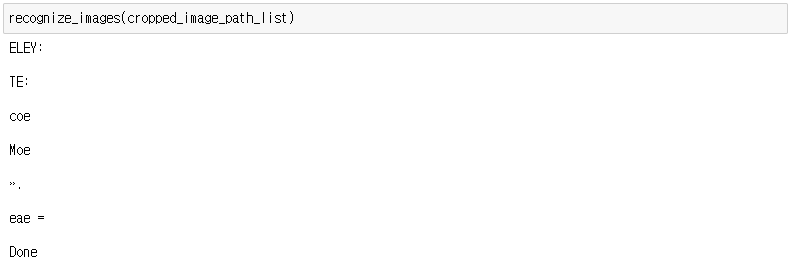

### case 3. lang = eng+kor 


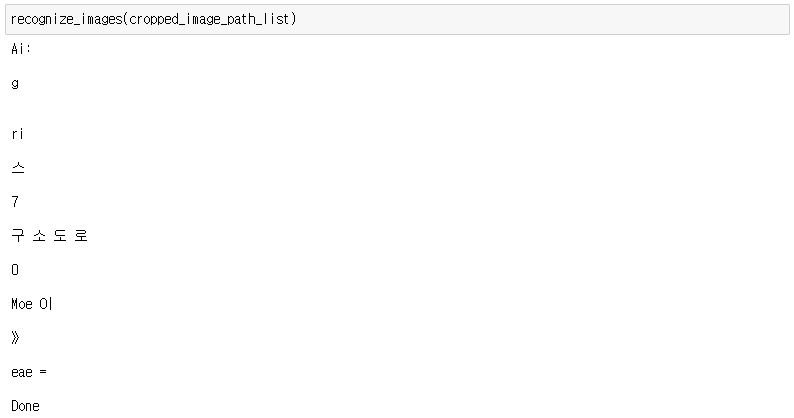

* LMS 에서 했던 글자 이미지 보다 훨신 정확도가 떨어진다. 글자가 선명하지 않고, 약간 틀어져 있는 상태라, 모델이 인식하기 힘들었던것으로 생각된다. 
* 참고) LMS 테서렉트 이미지 결과 값 
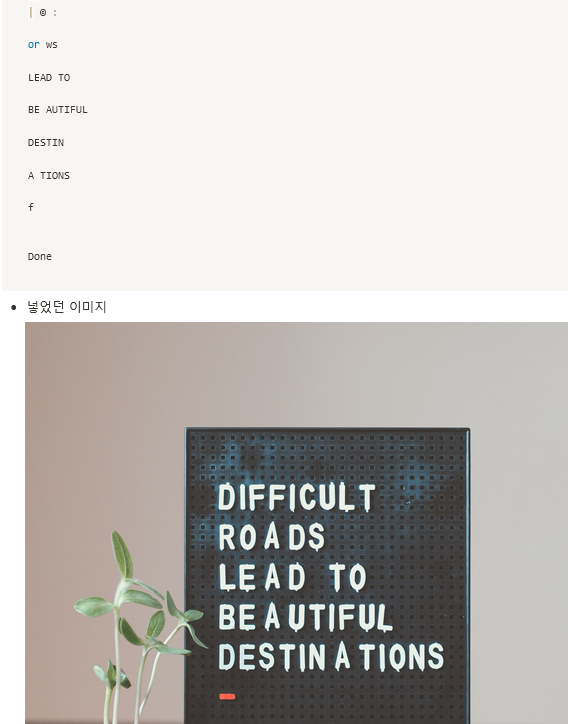





----





# 5. 세 모델 비교


* 실행 시켜보기 전 까진 구글>테서렉트>keras 순으로 성능이 나눠지지 않을까 예상했으나, 실제로 돌려보니 구글 api가 훨씬 월등했다. 오타나 이탈자 없이 모든 단어를 인식했고, 심지어 그림인 화살표도 인식하여 출력하였다. 
* keras-ocr도 한글 지원이 됬더라면, 구글 ocr 만큼 유용하게 사용할 수 있었겠지만, 한글 미지원 부분이 아쉽다. 또한, 영어 사이에 있는 숫자 1을 그대로 i로 인식해 버린 점은 조금 아쉬운 부분이라 할 수 있겠다. 
* 테서렉트.. 추가로 이미지를 주고 학습해 본다면 이미지 인식이 조금은 더 나아지지 않을까? 하는 기대를 품어본다. 무엇보다 한국어 지원이 되는 만큼 좀 더 성능을 올려서 사용 해 볼 수 있는 기회가 있었음 좋겠다:) 

### 구글 OCR API  
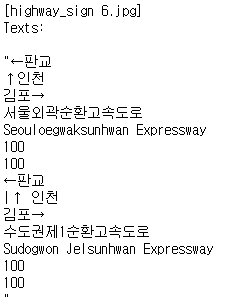

### Keras-ocr

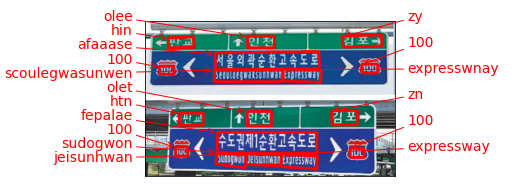





----





# 회고

* 재밌었다! 테서렉트가 정말 아쉽다.. lms 출력 값 보고 그래도 한글팩도 설치하면 잘 인식하겠지.. 싶었는데 너무 못 나왔다.. 노드 상에서 모델 학습 부분이 없어서 시도는 해 보진 않았는데, 성능을 올릴 수 있는 방법이 있다면 올려서 다시 시도 해 보고싶다. 





----





# 🖇️ 참고 페이지 

### 모든 파일과 디렉토리 리스트 반환

* [os.listdir() method](https://m.blog.naver.com/hankrah/221755651815)


### 구글 API 파일 하나씩 불러오기

* [강양인 김현지님 프로젝트](https://github.com/aacara/exploration/blob/main/e18_OCR.ipynb)


### 테서렉트 lang 2가지 

* [두가지 언어가 포함된 경우](https://gomguk.tistory.com/51)